# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Mateo Garcia Lopez

**Professor**: Pablo Camarillo Ramirez

# Introduction

### Problem Statement
In the world of online multiplayer gaming, a seamless and fair experience is really hard to find. One of the most disruptive technical issues that can undermine this experience is **desynchronization**, also known as "**De-sync**".

De-sync occurs when the game state on a player's machine deviates from the authoritative game state on the central server. In an ideal scenario, every player's computer and the server share the exact same understanding of the game world, where every player is, what actions they are performing, and the status of all in-game objects. (Obviously, on a perfect world, there aren't cheaters around, who can abuse all this data that is available for everyone)

However, due to network latency, packet loss, and differences in client-side processing, a player's view of the game can become momentarily inaccurate. This leads to frustrating gameplay scenarios such as:

- Rubber banding: A player appears to teleport back and forth (like stuck on time).
- Delayed hit registration: On competitive FPS (First Person Shooter) each milisecond that happens after the shot didn't register, could change the outcome of complete matches
- Ghost players: Opponents appear to be in one location, but are actually somewhere else, leading to unfair advantages.

These issues not only frustrate players, but can also damage a game's reputation and lead to a decline in its player base.

### Project Objective
To adapt a real-world game analytics challenge into a scalable batch processing pipeline. The objective is to build a robust system that can consume, transform, and persist large volumes of historical game telemetry data to analyze de-sync events.

Instead of focusing on real-time alerts, the goal is to ingest a batch of simulated raw game data, process it, and create persistence targets for analysis. This approach will involve the following steps:

- Data generation: Use a custom script to simulate 2 critical data streams: **player events** from the game clients and **server state snapshots**
- Data transformation: Ingest the raw data using Spark, clean it, and perform the key transformation of joining client-side and server-side data based on the player and session
- Analysis and aggregation: Calculate the magnitude of de-sync by comparing client and server possitions. Aggregate this data to identify correlations between de-sync events and network conditions like high ping or packet loss.
- Persistence: Store both the raw, and the clean tables into a database to support historical analysis and future applications (final project pt2 maybe?).

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, from_json, lit, sqrt, when, avg, count

# Initialize Spark Session with PostgreSQL JAR package
spark = SparkSession.builder \
    .appName("GameDesyncAnalysis") \
    .config("spark.jars.packages", "org.postgresql:postgresql:42.2.23") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

print("Spark Session created and configured for PostgreSQL.")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.postgresql#postgresql added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0c4b8bc7-56e2-4c0c-8d04-35e1bed3e544;1.0
	confs: [default]
	found org.postgresql#postgresql;42.2.23 in central
	found org.checkerframework#checker-qual;3.5.0 in central
:: resolution report :: resolve 124ms :: artifacts dl 3ms
	:: modules in use:
	org.checkerframework#checker-qual;3.5.0 from central in [default]
	org.postgresql#postgresql;42.2.23 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|     

Spark Session created and configured for PostgreSQL.


# Dataset

### Data Model and Schema
The data model is relational, consisting of two primary sources:
* **`player_events`**: Captures actions and positions as reported by the player's client.
* **`server_state`**: Captures the authoritative game state from the server, including server-side positions and network metrics.

The data will be generated by a Python script.

In [2]:
import sys
from mateogarcial.spark_utils import SparkUtils
from mateogarcial.vg_producer import VideogameDataProducer
import json
from datetime import datetime, timedelta

# --- 1. Define Schemas (No changes here) ---
player_event_columns = [
    ("event_id", "string"), ("session_id", "string"), ("player_id", "string"),
    ("event_type", "string"), ("timestamp", "timestamp"), ("client_position_x", "double"),
    ("client_position_y", "double"), ("client_position_z", "double")
]
server_state_columns = [
    ("state_id", "string"), ("session_id", "string"), ("player_id", "string"),
    ("timestamp", "timestamp"), ("server_position_x", "double"), ("server_position_y", "double"),
    ("server_position_z", "double"), ("ping", "int"), ("packet_loss", "double")
]
player_event_schema = SparkUtils.generate_schema(player_event_columns)
server_state_schema = SparkUtils.generate_schema(server_state_columns)

# --- 2. Generate Data using Updated Producer ---
producer = VideogameDataProducer()
num_records = 1000
session_id = "session_abc_123"
player_id = "player_xyz_789"

player_events_data = []
server_states_data = []

TICK_INTERVAL = timedelta(milliseconds=50) 
start_time = datetime.now()

for i in range(num_records):
    current_tick_time = start_time + (i * TICK_INTERVAL)

    # Generate the player event first to get the client's ground truth position
    p_event_json = producer.generate_player_event(session_id, player_id)
    p_event = json.loads(p_event_json)
    p_event['timestamp'] = current_tick_time
    player_events_data.append(p_event)

    # Extract the client position to pass to the server state generator
    client_position = {
        'x': p_event['client_position_x'],
        'y': p_event['client_position_y'],
        'z': p_event['client_position_z']
    }

    # Generate a server state that is correlated to the client's state
    s_state_json = producer.generate_server_state(session_id, player_id, client_position)
    s_state = json.loads(s_state_json)
    s_state['timestamp'] = current_tick_time
    server_states_data.append(s_state)


# --- 3. Create DataFrames ---
player_events_df = spark.createDataFrame(player_events_data, schema=player_event_schema)
server_state_df = spark.createDataFrame(server_states_data, schema=server_state_schema)

print("Player Events DataFrame:")
player_events_df.show(5, truncate=False)

print("Server State DataFrame:")
server_state_df.show(5, truncate=False)

Player Events DataFrame:


+------------------------------------+---------------+--------------+-----------+--------------------------+-----------------+-----------------+-----------------+
|event_id                            |session_id     |player_id     |event_type |timestamp                 |client_position_x|client_position_y|client_position_z|
+------------------------------------+---------------+--------------+-----------+--------------------------+-----------------+-----------------+-----------------+
|2388f33e-ff25-46e9-8f74-1b9ff750c8d7|session_abc_123|player_xyz_789|player_move|2025-10-28 00:33:36.450004|48.16            |88.88            |18.57            |
|e60ba95d-6792-4f0c-808e-03fa555eb9a8|session_abc_123|player_xyz_789|player_move|2025-10-28 00:33:36.500004|28.4             |16.31            |4.68             |
|5fa6bc9e-8a03-4583-ac29-3e477d36568c|session_abc_123|player_xyz_789|player_move|2025-10-28 00:33:36.550004|59.22            |98.62            |16.77            |
|11d52547-9234-4e53-9c

# Transformations and Actions

In this section, the two data streams are joined and processed to derive analytical insights.

 1.  **Join DataFrames**: An inner join combines `player_events_df` and `server_state_df` on `session_id`, `player_id`, and `timestamp`.
 2.  **Calculate De-Sync Distance**: A new column, `desync_distance`, is created by calculating the Euclidean distance between the client and server positions.
 3.  **Feature Engineering**: A boolean flag `is_desynced` is added to easily identify significant de-sync events (distance > 1.0). Another column, `ping_category`, is created to group ping values for easier analysis.
 4.  **Aggregations**: Two summary DataFrames are created to analyze the relationship between network conditions and de-sync:
     * `desync_by_ping_df`: Groups by `ping_category`.
     * `desync_by_packet_loss_df`: Groups by `packet_loss`.

In [3]:
from pyspark.sql.functions import pow

# --- 1. Join the DataFrames ---
joined_df = player_events_df.join(
    server_state_df,
    ["session_id", "player_id", "timestamp"],
    "inner"
)

# --- 2. Calculate De-Sync Distance ---
desync_df = joined_df.withColumn(
    "desync_distance",
    F.sqrt(
        F.pow(F.col("server_position_x") - F.col("client_position_x"), 2) +
        F.pow(F.col("server_position_y") - F.col("client_position_y"), 2) +
        F.pow(F.col("server_position_z") - F.col("client_position_z"), 2)
    )
)

# --- 3. Feature Engineering ---
analysis_df = desync_df.withColumn("is_desynced", F.when(F.col("desync_distance") > 1.0, True).otherwise(False)) \
                       .withColumn("ping_category", F.when(F.col("ping") < 50, "low")
                                                  .when(F.col("ping") < 150, "medium")
                                                  .otherwise("high"))

print("Schema of the final analysis DataFrame:")
analysis_df.printSchema()
analysis_df.show(10)


# --- 4. Aggregations (UPDATED) ---
# Aggregate 1: Analyze de-sync by ping category
desync_by_ping_df = analysis_df.groupBy("ping_category") \
    .agg(
        F.avg("desync_distance").alias("average_desync_distance"),
        F.count(F.when(F.col("is_desynced") == True, True)).alias("desync_event_count"),
        F.count(F.when(F.col("is_desynced") == False, True)).alias("in_sync_event_count")
    ) \
    .orderBy("ping_category")

# Aggregate 2: Analyze de-sync by packet loss
desync_by_packet_loss_df = analysis_df.groupBy("packet_loss") \
    .agg(
        F.avg("desync_distance").alias("average_desync_distance"),
        F.count(F.when(F.col("is_desynced") == True, True)).alias("desync_event_count"),
        F.count(F.when(F.col("is_desynced") == False, True)).alias("in_sync_event_count")
    ) \
    .orderBy("packet_loss")


print("De-Sync Analysis by Ping Category:")
desync_by_ping_df.show()

print("De-Sync Analysis by Packet Loss:")
desync_by_packet_loss_df.show()

Schema of the final analysis DataFrame:
root
 |-- session_id: string (nullable = true)
 |-- player_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- event_id: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- client_position_x: double (nullable = true)
 |-- client_position_y: double (nullable = true)
 |-- client_position_z: double (nullable = true)
 |-- state_id: string (nullable = true)
 |-- server_position_x: double (nullable = true)
 |-- server_position_y: double (nullable = true)
 |-- server_position_z: double (nullable = true)
 |-- ping: integer (nullable = true)
 |-- packet_loss: double (nullable = true)
 |-- desync_distance: double (nullable = true)
 |-- is_desynced: boolean (nullable = false)
 |-- ping_category: string (nullable = false)



+---------------+--------------+--------------------+--------------------+-----------+-----------------+-----------------+-----------------+--------------------+------------------+------------------+------------------+----+-----------+------------------+-----------+-------------+
|     session_id|     player_id|           timestamp|            event_id| event_type|client_position_x|client_position_y|client_position_z|            state_id| server_position_x| server_position_y| server_position_z|ping|packet_loss|   desync_distance|is_desynced|ping_category|
+---------------+--------------+--------------------+--------------------+-----------+-----------------+-----------------+-----------------+--------------------+------------------+------------------+------------------+----+-----------+------------------+-----------+-------------+
|session_abc_123|player_xyz_789|2025-10-28 00:33:...|0c95fd35-ebcb-41b...|player_move|             66.7|            31.06|            19.41|47275aa0-c429-4e9

+-------------+-----------------------+------------------+-------------------+
|ping_category|average_desync_distance|desync_event_count|in_sync_event_count|
+-------------+-----------------------+------------------+-------------------+
|         high|      4.699677141861712|               421|                 92|
|          low|     1.9064242753270486|                45|                 84|
|       medium|      2.988848137777241|               188|                170|
+-------------+-----------------------+------------------+-------------------+

De-Sync Analysis by Packet Loss:


+-----------+-----------------------+------------------+-------------------+
|packet_loss|average_desync_distance|desync_event_count|in_sync_event_count|
+-----------+-----------------------+------------------+-------------------+
|        0.0|     2.7904456116887495|                26|                 27|
|       0.01|     3.1645633962362805|                48|                 38|
|       0.02|      2.986506359519767|                55|                 52|
|       0.03|     2.6546006908713586|                46|                 57|
|       0.04|      3.461737284813416|                58|                 42|
|       0.05|     2.8321919468468577|                52|                 49|
|       0.06|      4.873453202317033|                91|                 15|
|       0.07|      4.762939696681935|                85|                 17|
|       0.08|      4.298116513321431|                73|                 18|
|       0.09|       4.60966225084741|                77|                 21|

# Persistence Data

### Database Justification: PostgreSQL
PostgreSQL is selected as the persistence solution due to its robust support for relational data, making it ideal for storing the structured and aggregated results of our analysis. Its reliability and powerful SQL querying capabilities are perfect for historical analysis and for serving data to BI tools or machine learning models.

### Persistence Strategy
The following tables will be created in the `desync_db` database:
* **`desync_events`**: The main, cleaned table containing detailed information for every correlated client/server event.
* **`desync_by_ping`**: The aggregated summary table for ping analysis.
* **`desync_by_packet_loss`**: The aggregated summary table for packet loss analysis.

In [5]:
# --- 1. PostgreSQL Connection Configuration ---
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/desync_db"
table_properties = {
    "user": "postgres",
    "password": "Admin@1234",
    "driver": "org.postgresql.Driver"
}

# --- 2. Write DataFrames to PostgreSQL ---

# Write the main analysis table
print("Writing detailed desync_events table to PostgreSQL...")
analysis_df.write \
    .mode("overwrite") \
    .jdbc(url=jdbc_url, table="desync_events", properties=table_properties)
print("Successfully saved desync_events.")


# Write the ping aggregation table
print("Writing desync_by_ping summary table...")
desync_by_ping_df.write \
    .mode("overwrite") \
    .jdbc(url=jdbc_url, table="desync_by_ping", properties=table_properties)
print("Successfully saved desync_by_ping.")


# Write the packet loss aggregation table
print("Writing desync_by_packet_loss summary table...")
desync_by_packet_loss_df.write \
    .mode("overwrite") \
    .jdbc(url=jdbc_url, table="desync_by_packet_loss", properties=table_properties)
print("Successfully saved desync_by_packet_loss.")

print("\nAll data has been persisted to PostgreSQL.")

Writing detailed desync_events table to PostgreSQL...


Successfully saved desync_events.
Writing desync_by_ping summary table...


Successfully saved desync_by_ping.
Writing desync_by_packet_loss summary table...
Successfully saved desync_by_packet_loss.

All data has been persisted to PostgreSQL.


# DAG

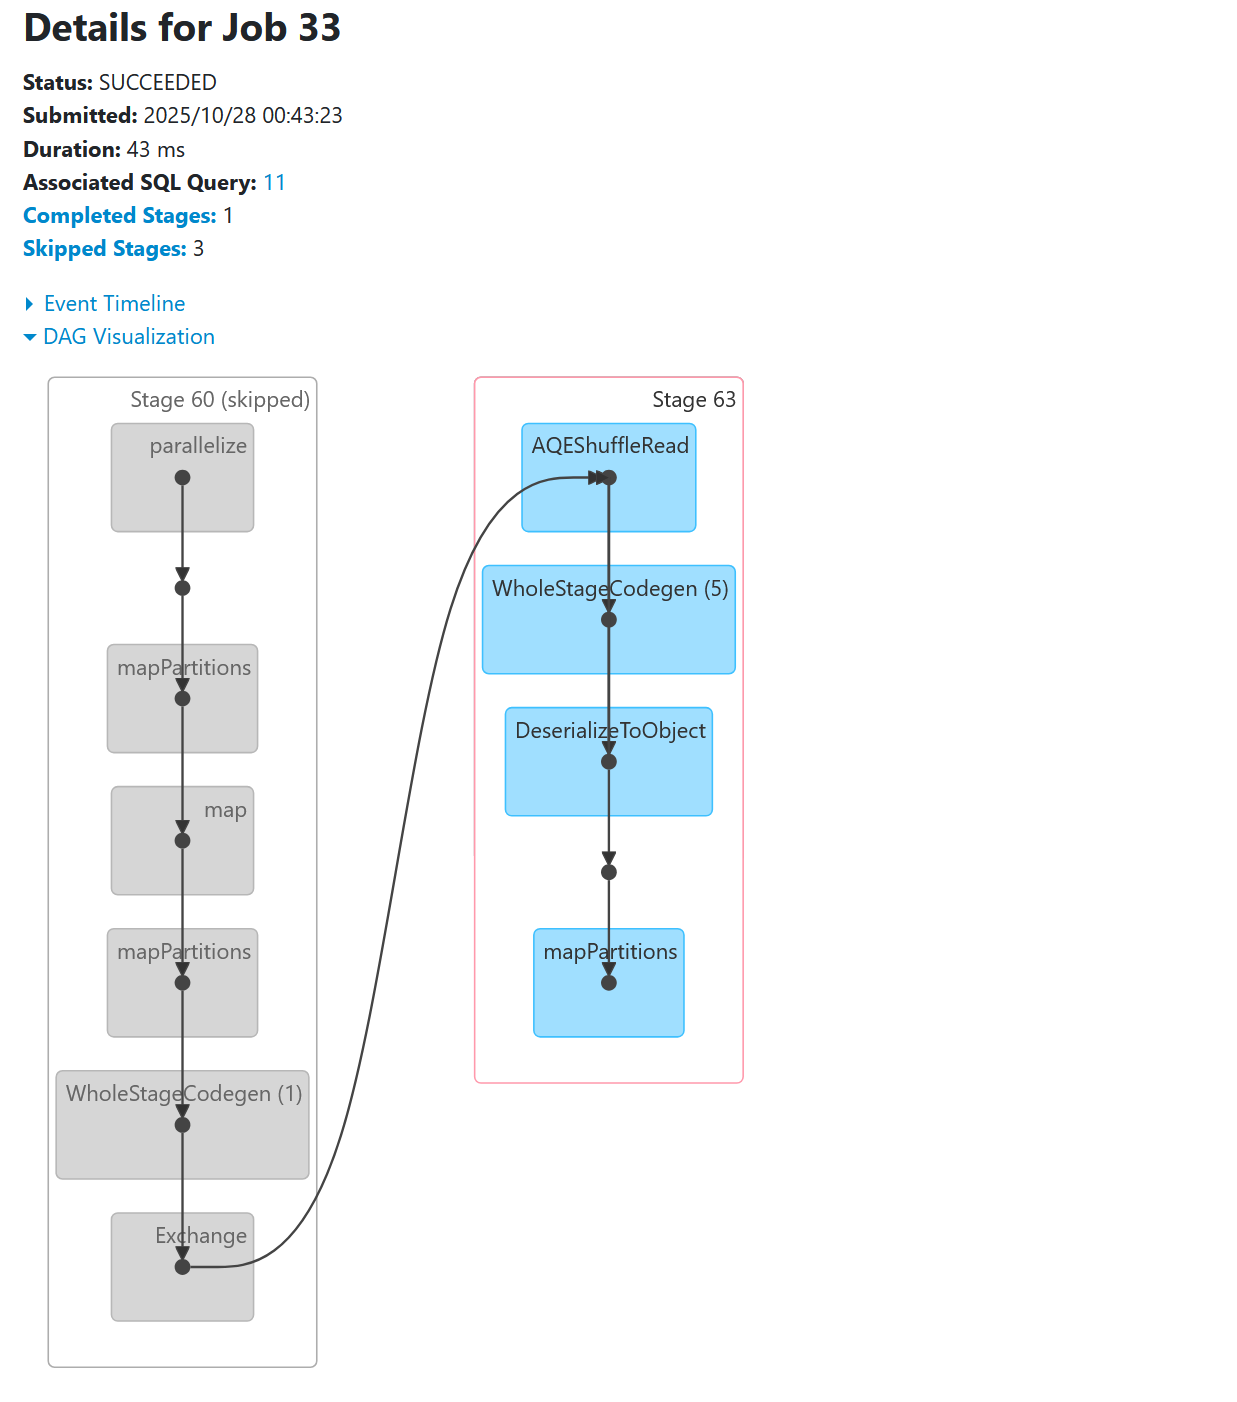

# Results

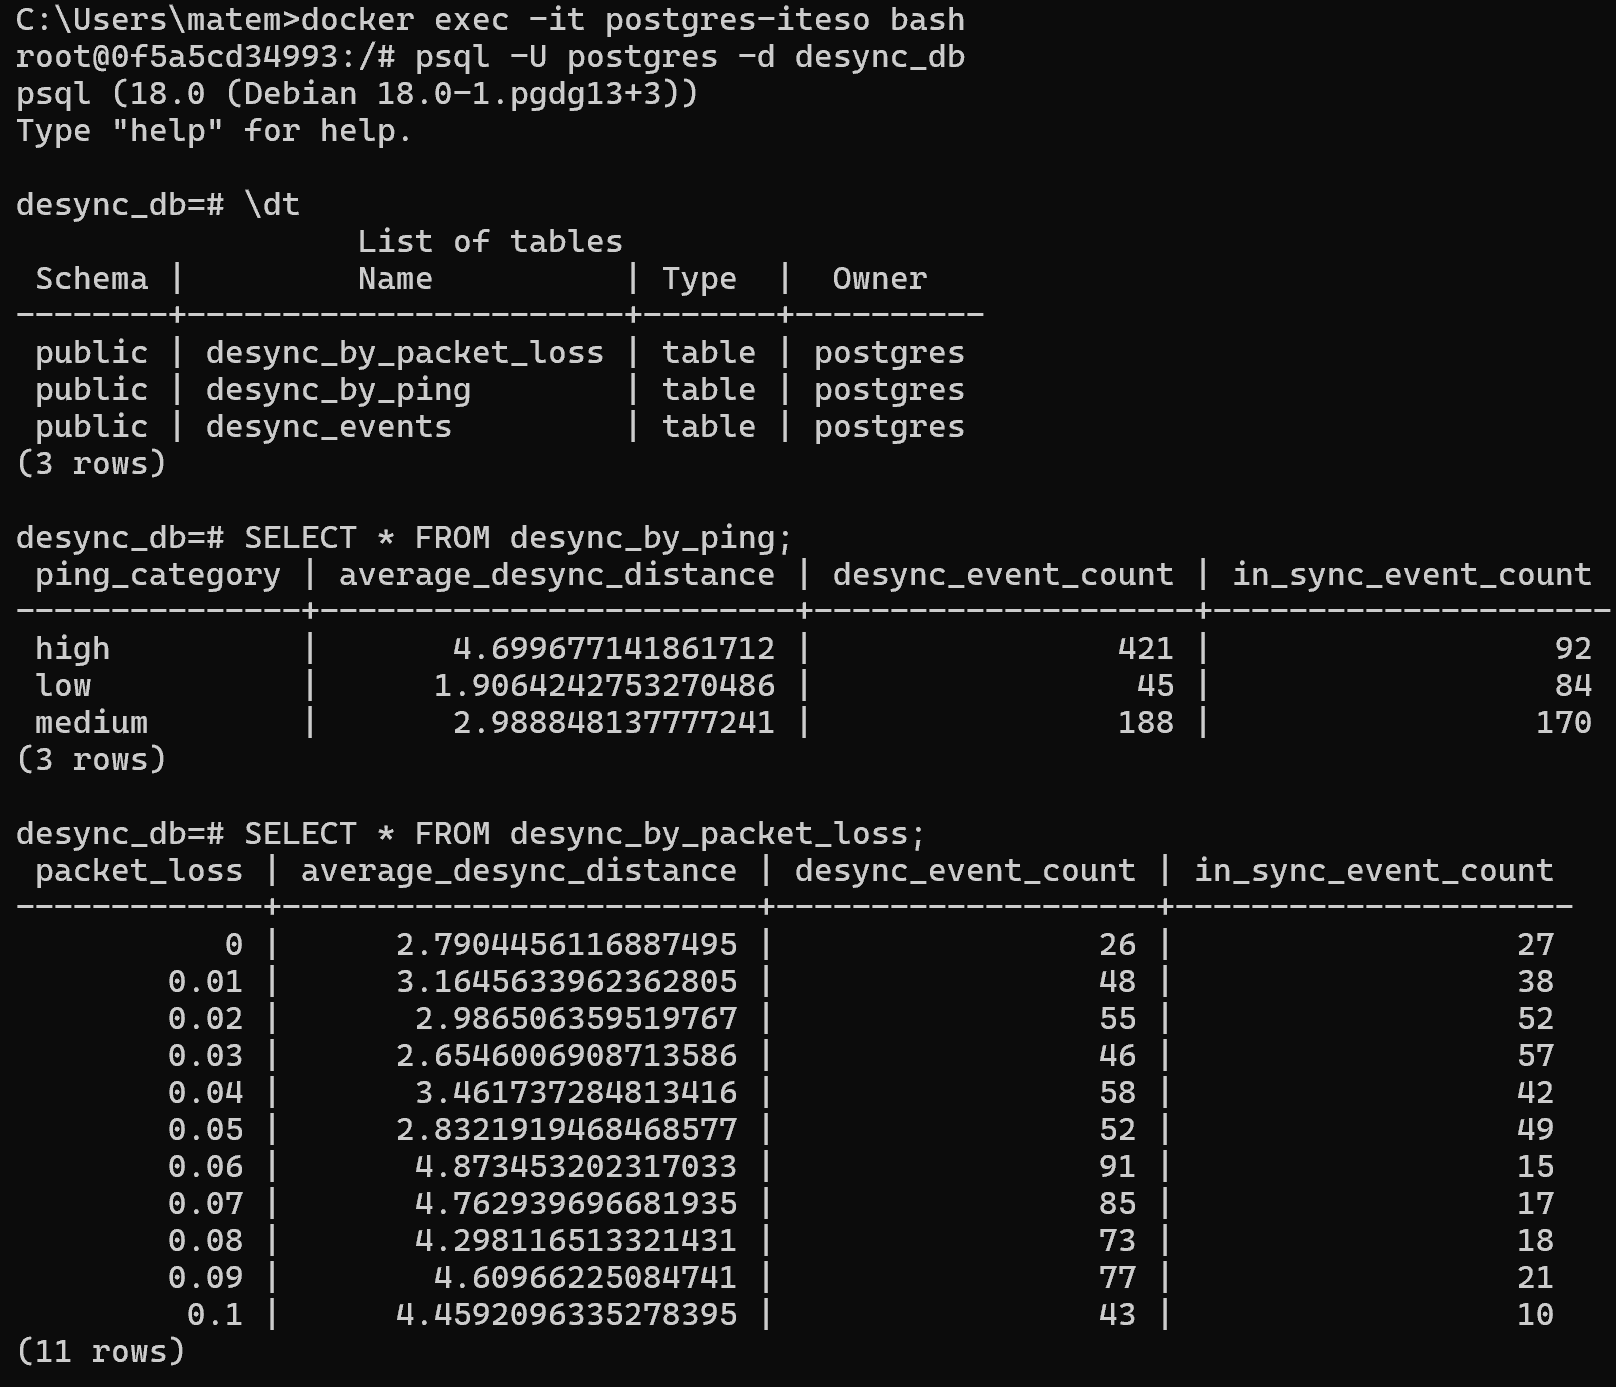

In [6]:
sc.stop()
spark.stop()